<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Задача: построить модель с предельно большим значением *F1*-меры (не менее 0.59 на тестовой выборке).

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Для начала загрузим и изучим данные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#настройка формата отображения чисел
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Т.к. природа пропусков в столбце `Tenure` неизвестна, заполним их случайными значениями в диапазоне от минимального до максимального имеющихся значений, чтобы не повлиять на распределение:

In [6]:
data['Tenure'] = data['Tenure'].fillna(np.random.randint(data['Tenure'].min(), data['Tenure'].max() + 1))

# убедимся, что характеристики распределения существенно не изменились
data['Tenure'].describe()

count   10,000.00
mean         4.54
std          3.11
min          0.00
25%          2.00
50%          4.00
75%          7.00
max         10.00
Name: Tenure, dtype: float64

In [7]:
#проверим успешность заполнения пропущенных значений
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Датасет изучен и предобработан (заполнены пропуски в столбце `Tenure`), существенные выбросы не обнаружен. Можно приступать к обучению моделей.

## Исследование задачи

В данном разделе исследуем дисбаланс классов, а также обучим модель линейной регрессии без учета дисбаланса.

In [8]:
#посчитаем долю клиентов, ушедших из банка
print("Доля клиентов, ушедших из банка:", data['Exited'].mean())

Доля клиентов, ушедших из банка: 0.2037


Наблюдается несбалансированность классов - доля ушедших клиентов составляет 20.37%.

Подготовим данные для обучения моделей: закодируем качественные признаки с помощью OHE и стандартизируем количественные признаки.

In [9]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


При разделении датасета оставим только информативные признаки.

In [10]:
#разделим датасет на фичи и целевой признак
features = data.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
target = data['Exited']

print("Размер датасета с фичами:", features.shape)
print("Размер датасета с целевым признаком:", target.shape)

Размер датасета с фичами: (10000, 10)
Размер датасета с целевым признаком: (10000,)


In [11]:
#кодирование качественных признаков методом OHE
features_ohe = pd.get_dummies(features, drop_first=True)

In [12]:
features_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.00,0.00,1,1,1,"101,348.88",False,False,False
1,608,41,1.00,"83,807.86",1,0,1,"112,542.58",False,True,False
2,502,42,8.00,"159,660.80",3,1,0,"113,931.57",False,False,False
3,699,39,1.00,0.00,2,0,0,"93,826.63",False,False,False
4,850,43,2.00,"125,510.82",1,1,1,"79,084.10",False,True,False


In [13]:
#разобьем датасет на выборки (тренировочную, валидационную, тестовую)
features_train_unbalanced, features_valid_test, target_train_unbalanced, target_valid_test = train_test_split(
    features_ohe, target, random_state = 42, train_size=0.6
)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, random_state = 42, train_size=0.5
)

print("Размер обучающей выборки и целевого признака", features_train_unbalanced.shape, 
                                                      target_train_unbalanced.shape)
print("Размер валидационной выборки и целевого признака", features_valid.shape, target_valid.shape)
print("Размер тестовой выборки и целевого признака", features_test.shape, target_test.shape)

Размер обучающей выборки и целевого признака (6000, 11) (6000,)
Размер валидационной выборки и целевого признака (2000, 11) (2000,)
Размер тестовой выборки и целевого признака (2000, 11) (2000,)


In [14]:
#определение числовых признаков, которые необходимо масштабировать
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',  'EstimatedSalary']

In [15]:
#настройка скелера на обучающем датасете
scaler = StandardScaler()
scaler.fit(features_train_unbalanced[numerical])

#игнорирование предупреждения об ошибки при записи масштабированных признаков в исходный датафрейм
pd.options.mode.chained_assignment = None

#масштабирование количественных признаков в обучающей, валидационной и тестовой выборках
features_train_unbalanced[numerical] = scaler.transform(features_train_unbalanced[numerical])
features_valid[numerical] = scaler.transform(features_valid[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

features_train_unbalanced[numerical].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,"6,000.00","6,000.00","6,000.00","6,000.00","6,000.00","6,000.00"
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.14,-2.00,-1.46,-1.21,-0.91,-1.75
25%,-0.69,-0.66,-0.81,-1.21,-0.91,-0.85
50%,0.01,-0.18,-0.17,0.32,-0.91,-0.00
75%,0.70,0.49,0.80,0.83,0.82,0.86
max,2.05,5.10,1.76,2.80,4.28,1.71


Стандартное отклонение выбранных признаков равно единице, а среднее нулю. Стандартизация выполнена успешно.

Обучим модель линейной регрессии без учета дисбаланса классов:

In [16]:
linear_model = LogisticRegression(solver='lbfgs', random_state=42)
linear_model.fit(features_train_unbalanced, target_train_unbalanced)
linear_predictions_valid_unbalanced = linear_model.predict(features_valid)
linear_predictions_train_unbalanced = linear_model.predict(features_train_unbalanced)

f1_valid_unbalanced = f1_score(target_valid, linear_predictions_valid_unbalanced)
f1_train_unbalanced = f1_score(target_train_unbalanced, linear_predictions_train_unbalanced)

roc_auc_valid_unbalanced = roc_auc_score(target_valid, linear_model.predict_proba(features_valid)[:,1])

print("Метрики предсказаний линейной модели, обученной на несбалансированной выборке")
print()
print("F1-мера на тренировочной выборке", round(f1_train_unbalanced, 2))
print("F1-мера на валидационной выборке", round(f1_valid_unbalanced, 2))
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_unbalanced, 2))

Метрики предсказаний линейной модели, обученной на несбалансированной выборке

F1-мера на тренировочной выборке 0.32
F1-мера на валидационной выборке 0.3
Метрика AUC-ROC на валидационной выборке 0.75


Мы получили достаточно низкое значение F1-меры с помощью модели, обученной на несбалансированной выборке. Значение метрики ROC-AUC выше, чем у случайной модели (0.5), однако не слишком высокое.

## Борьба с дисбалансом

Для борьбы с дисбалансом классов применим несколько методов: взвешивание классов, upsampling и downsampling.

Напишем функции для обучения и подбора гиперпараметров различных моделей: логистической регрессии, решающего дерева и случайного леса.

In [17]:
#функция для обучения модели логистической регрессии
def log_regression(features_train, target_train, features_valid, 
                  target_valid, class_weight, random_state, solver):
    
    model = LogisticRegression(random_state=random_state, class_weight=class_weight, solver=solver)
    model.fit(features_train, target_train)
    
    predictions_train = model.predict(features_train_unbalanced)
    predictions_valid = model.predict(features_valid)
    
    f1_train = f1_score(target_train_unbalanced, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    roc_auc_valid = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    
    return f1_train, f1_valid, roc_auc_valid

In [18]:
#функция для обучения модели и подбора гиперпараметров решающего дерева

def decision_tree_cl(features_train, target_train, features_valid, 
                  target_valid, class_weight, random_state):
    
    best_model = None
    best_depth = 0
    best_f1_valid = 0
    
    
    for depth in range(1, 15):
        model = DecisionTreeClassifier(max_depth=depth, random_state=random_state, class_weight=class_weight)
        model.fit(features_train, target_train)

        predictions_valid = model.predict(features_valid)
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1_valid:
            best_f1_valid = f1_valid
            best_depth = depth
            best_model = model

            
    predictions_train = model.predict(features_train_unbalanced)        
    f1_train = f1_score(target_train_unbalanced, predictions_train)
    roc_auc_valid = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    
    return f1_train, best_f1_valid, best_depth, roc_auc_valid

In [19]:
#функция для обучения модели и подбора гиперпараметров случайного леса

def random_forest_cl(features_train, target_train, features_valid, 
                  target_valid, class_weight, random_state):

#подбор лучшего значения глубины дерева
    best_model = None
    best_depth = 0
    best_f1_valid = 0
    
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=random_state, 
                                       class_weight=class_weight)
        model.fit(features_train, target_train)

        predictions_valid = model.predict(features_valid)
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1_valid:
            best_f1_valid = f1_valid
            best_depth = depth
            best_model = model
    
    
#подбор лучшего значения количества деревьев   
    best_n_estimators = 10
    
    for n in range(10, 200, 10):
        model = RandomForestClassifier(n_estimators=n, max_depth=best_depth, random_state=random_state, 
                                       class_weight=class_weight)
        model.fit(features_train, target_train)

        predictions_valid = model.predict(features_valid)
        
        f1_valid = f1_score(target_valid, predictions_valid)
        
        if f1_valid > best_f1_valid:
            best_f1_valid = f1_valid
            best_n_estimators = n
            best_model = model
            
    predictions_train = model.predict(features_train_unbalanced)        
    f1_train = f1_score(target_train_unbalanced, predictions_train)
    roc_auc_valid = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    
    return f1_train, best_f1_valid, best_depth, best_n_estimators, roc_auc_valid

### Взвешивание классов

Для применения данного метода борьбы с несбалансированностью классов будем обучать модели со значением параметра `class_weight` равным `balanced`.

In [20]:
#логистическая регрессия
f1_train_LR_balanced, f1_valid_LR_balanced, roc_auc_valid_LR_balanced = log_regression(
    features_train_unbalanced, target_train_unbalanced, features_valid, target_valid, 
    class_weight='balanced', random_state=42, solver='lbfgs'
)

print("Метрики предсказаний линейной модели, обученной с взвешиванием классов")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_LR_balanced, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_LR_balanced, 2))
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_LR_balanced, 2))

Метрики предсказаний линейной модели, обученной с взвешиванием классов

F-1 мера на тренировочной выборке 0.5
F-1 мера на валидационной выборке 0.46
Метрика AUC-ROC на валидационной выборке 0.75


In [21]:
#решающее дерево

f1_train_DT_balanced, f1_valid_DT_balanced, best_depth, roc_auc_valid_DT_balanced = decision_tree_cl(
    features_train_unbalanced, target_train_unbalanced, features_valid, target_valid,
    class_weight='balanced', random_state=42)

print("Метрики предсказаний модели решающего дерева, обученной с взвешиванием классов")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_DT_balanced, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_DT_balanced, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_DT_balanced, 2))

Метрики предсказаний модели решающего дерева, обученной с взвешиванием классов

F-1 мера на тренировочной выборке 0.89
F-1 мера на валидационной выборке 0.53
Глубина дерева в лучшей модели: 7
Метрика AUC-ROC на валидационной выборке 0.69


In [22]:
#случайный лес

f1_train_RF_balanced, f1_valid_RF_balanced, best_depth, best_n_estimators, roc_auc_valid_RF_balanced = (
    random_forest_cl(features_train_unbalanced, target_train_unbalanced, features_valid, target_valid,
                    class_weight='balanced', random_state=42))

print("Метрики предсказаний модели случайного леса, обученной с взвешиванием классов")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_RF_balanced, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_RF_balanced, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Количество деревьев в лучшей модели:", best_n_estimators)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_RF_balanced, 2))

Метрики предсказаний модели случайного леса, обученной с взвешиванием классов

F-1 мера на тренировочной выборке 0.98
F-1 мера на валидационной выборке 0.58
Глубина дерева в лучшей модели: 14
Количество деревьев в лучшей модели: 160
Метрика AUC-ROC на валидационной выборке 0.84


При использовании метода взвешивания классов наиболее точной оказалась модель случайного леса с количеством деревьев 160 и глубиной каждого дерева 14, значение F1-меры которой на валидационной выборке оказалось равно 58%, значение метрики ROC-AUC составило 84%.

### Upsampling

Преобразуем тренировочную выборку методом апсэмплинга.

In [23]:
#напишем функцию для апсэмплинга

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [24]:
#определим необходимое количество умножений наименьшего класса на основе 
#пропорциональности в исходном датасете
repeat = round(1 / data['Exited'].mean())

#проведем апсэмплинг тренировочной выборки
features_train_upsampled, target_train_upsampled = upsample(
    features_train_unbalanced, target_train_unbalanced, repeat)

#проверим полученные значения
print("Доля положительных классов в upsampled датасете:", target_train_upsampled.mean())

Доля положительных классов в upsampled датасете: 0.5624312431243125


Обучим модели на upsampled выборке и подберем оптимальные гиперпараметры.

In [25]:
#логистическая регрессия
f1_train_LR_upsampled, f1_valid_LR_upsampled, roc_auc_valid_LR_upsampled = log_regression(
    features_train_upsampled, target_train_upsampled, features_valid, target_valid, 
    class_weight=None, random_state=42, solver='lbfgs'
)

print("Метрики предсказаний линейной модели, обученной на увеличенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_LR_upsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_LR_upsampled, 2))
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_LR_upsampled, 2))

Метрики предсказаний линейной модели, обученной на увеличенной выборке

F-1 мера на тренировочной выборке 0.49
F-1 мера на валидационной выборке 0.45
Метрика AUC-ROC на валидационной выборке 0.75


In [26]:
#решающее дерево

f1_train_DT_upsampled, f1_valid_DT_upsampled, best_depth, roc_auc_valid_DT_upsampled = decision_tree_cl(
    features_train_upsampled, target_train_upsampled, features_valid, target_valid,
    class_weight=None, random_state=42)

print("Метрики предсказаний модели решающего дерева, обученной на увеличенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_DT_upsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_DT_upsampled, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_DT_upsampled, 2))

Метрики предсказаний модели решающего дерева, обученной на увеличенной выборке

F-1 мера на тренировочной выборке 0.86
F-1 мера на валидационной выборке 0.51
Глубина дерева в лучшей модели: 7
Метрика AUC-ROC на валидационной выборке 0.7


In [27]:
#случайный лес

f1_train_RF_upsampled, f1_valid_RF_upsampled, best_depth, best_n_estimators, roc_auc_valid_RF_upsampled = 
        (random_forest_cl(features_train_upsampled, target_train_upsampled, features_valid, target_valid,
                          class_weight=None, random_state=42))

print("Метрики предсказаний модели случайного леса, обученной на увеличенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_RF_upsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_RF_upsampled, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Количество деревьев в лучшей модели:", best_n_estimators)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_RF_upsampled, 2))

Метрики предсказаний модели случайного леса, обученной на увеличенной выборке

F-1 мера на тренировочной выборке 0.96
F-1 мера на валидационной выборке 0.58
Глубина дерева в лучшей модели: 14
Количество деревьев в лучшей модели: 170
Метрика AUC-ROC на валидационной выборке 0.83


При использовании метода апсэмплинга наиболее точной оказалась модель случайного леса с количеством деревьев 170 и глубиной каждого дерева 14, значение F1-меры которой на валидационной выборке оказалось равно 58%, значение метрики ROC-AUC 83%.

### Downsampling

Преобразуем тренировочную выборку методом даунсэмплинга.

In [28]:
#напишем функцию для даунсэмплинга

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [29]:
#определим необходимое количество делений наибольшего класса на основе 
#пропорциональности в исходном датасете
fraction = data['Exited'].mean()

#проведем даунсэмплинг тренировочной выборки
features_train_downsampled, target_train_downsampled = downsample(
    features_train_unbalanced, target_train_unbalanced, fraction)

#проверим полученные значения
print("Доля положительных классов в downsampled датасете:", round(target_train_downsampled.mean(), 2))

Доля положительных классов в downsampled датасете: 0.56


Обучим модели на downsampled выборке и подберем оптимальные гиперпараметры.

In [30]:
#логистическая регрессия
f1_train_LR_downsampled, f1_valid_LR_downsampled, roc_auc_valid_LR_downsampled = log_regression(
    features_train_downsampled, target_train_downsampled, features_valid, target_valid, 
    class_weight=None, random_state=42, solver='lbfgs'
)

print("Метрики предсказаний линейной модели, обученной на уменьшенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_LR_downsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_LR_downsampled, 2))
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_LR_downsampled, 2))

Метрики предсказаний линейной модели, обученной на уменьшенной выборке

F-1 мера на тренировочной выборке 0.49
F-1 мера на валидационной выборке 0.44
Метрика AUC-ROC на валидационной выборке 0.75


In [31]:
#решающее дерево

f1_train_DT_downsampled, f1_valid_DT_downsampled, best_depth, roc_auc_valid_DT_downsampled = decision_tree_cl(
    features_train_downsampled, target_train_downsampled, features_valid, target_valid,
    class_weight=None, random_state=42)

print("Метрики предсказаний модели решающего дерева, обученной на уменьшенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_DT_downsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_DT_downsampled, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_DT_downsampled, 2))

Метрики предсказаний модели решающего дерева, обученной на уменьшенной выборке

F-1 мера на тренировочной выборке 0.65
F-1 мера на валидационной выборке 0.52
Глубина дерева в лучшей модели: 3
Метрика AUC-ROC на валидационной выборке 0.67


In [32]:
#случайный лес

f1_train_RF_downsampled, f1_valid_RF_downsampled, best_depth, best_n_estimators, roc_auc_valid_RF_downsampled = (
                    random_forest_cl(features_train_downsampled, 
                                     target_train_downsampled, features_valid, target_valid,
                                    class_weight=None, random_state=42))

print("Метрики предсказаний модели случайного леса, обученной на уменьшенной выборке")
print()
print("F-1 мера на тренировочной выборке", round(f1_train_RF_downsampled, 2))
print("F-1 мера на валидационной выборке", round(f1_valid_RF_downsampled, 2))
print("Глубина дерева в лучшей модели:", best_depth)
print("Количество деревьев в лучшей модели:", best_n_estimators)
print("Метрика AUC-ROC на валидационной выборке", round(roc_auc_valid_RF_downsampled, 2))

Метрики предсказаний модели случайного леса, обученной на уменьшенной выборке

F-1 мера на тренировочной выборке 0.62
F-1 мера на валидационной выборке 0.52
Глубина дерева в лучшей модели: 8
Количество деревьев в лучшей модели: 190
Метрика AUC-ROC на валидационной выборке 0.83


При использовании метода апсэмплинга наиболее точной оказалась модель случайного леса с количеством деревьев 190 и глубиной каждого дерева 8, значение F1-меры которой на валидационной выборке оказалось равно 52%, метрики ROC-AUC 83%.

## Тестирование модели

Наилучший результат был получен с помощью модели случайного леса с количеством деревьев 160 и глубиной каждого дерева 14 при применении взвешивания весов в качестве метода борьбы с дисбалансом классов в датасете.

Проверим модель с данным параметрами на тестовой выборке.

In [33]:
model = RandomForestClassifier(n_estimators=160, max_depth=14, random_state=42, 
                                       class_weight='balanced')
model.fit(features_train_unbalanced, target_train_unbalanced)

predictions_test = model.predict(features_test)
f1_test = f1_score(target_test, predictions_test)

predictions_train = model.predict(features_train_unbalanced)        
f1_train = f1_score(target_train_unbalanced, predictions_train)


print("Значение F1-меры предсказаний модели случайного леса, обученной с взвешиванием классов,")
print("на обучающей выборке", round(f1_train, 2))
print()

print("Значение F1-меры предсказаний модели случайного леса, обученной с взвешиванием классов,")
print("на тестовой выборке", round(f1_test, 2))

Значение F1-меры предсказаний модели случайного леса, обученной с взвешиванием классов,
на обучающей выборке 0.98

Значение F1-меры предсказаний модели случайного леса, обученной с взвешиванием классов,
на тестовой выборке 0.61


Данная модель позволила успешно решить задачу по достижению F1-меры, равной 0.59, на тестовой выборке.

Измерим также метрику AUC-ROC на данной модели.

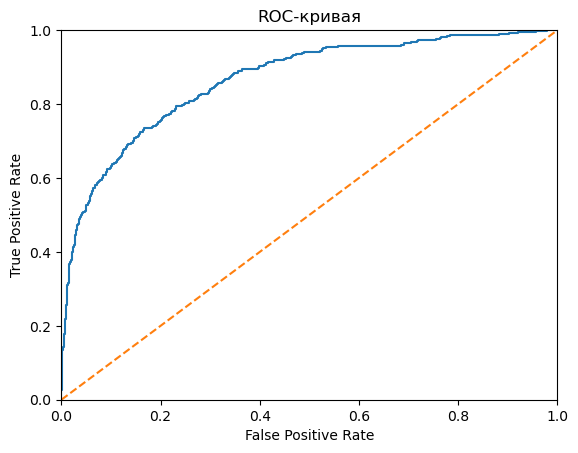

In [34]:
#построим ROC-кривую
probabilities_one_test = model.predict_proba(features_test)[:,1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [35]:
#посчитаем значение площади ROC-кривой
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("Значение AUC-ROC равно", round(auc_roc, 2))

Значение AUC-ROC равно 0.86


Значение площади под кривой больше 0.5, значит наша модель справляется с задачей успешнее, чем случайная модель.

Для оценки важности признаков в получившейся модели, выведем их важность с помощью `feature_importances_`.

In [36]:
feature_names = features_train_unbalanced.columns
feature_importances = model.feature_importances_

(pd.DataFrame({'features': feature_names, 'feature_importances': feature_importances})
             .sort_values('feature_importances', ascending=False).reset_index(drop=True))

,features,feature_importances
0,Age,0.26
1,NumOfProducts,0.15
2,Balance,0.14
3,EstimatedSalary,0.13
4,CreditScore,0.12
5,Tenure,0.07
6,IsActiveMember,0.04
7,Geography_Germany,0.03
8,Gender_Male,0.02
9,HasCrCard,0.02


Наибольший вклад в вероятность ухода клиента вносят такие переменные как возраст клиента и количество открытых продуктов.

## Вывод

На основе полученных и обработанных данных мы протестировали различные модели классификаторов (логистическую регрессию, решающее дерево, случайный лес).

Для решения проблемы несбалансированности выборки мы проанализировали эффективность различных методов (взвешивание классов, апсэмплинг, даунсэмплинг).

Моделью с наибольшим значением метрики F1 оказалась модель случайного леса (количество деревьев 160, глубина дерева 14), обученная с применением взвешивания классов. Значение F1-меры данной модели на тестовой выборке составило 0.61, значение AUC-ROC - 0.86.

Наибольший вклад в вероятность ухода клиента вносят такие переменные как возраст клиента и количество открытых продуктов.